<a href="https://colab.research.google.com/github/cbsobral/nlp-supervisor-recommender/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem set 2

## Team
Please write here your names and team number.

* Team name: C
* Team members: Henry Baker, Carol Sobral, Shruti Kakade

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [ ]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

You will be working with the LFW (Labeled Faces in the Wild) dataset. The dataset contains 13233 pictures of 5749 people. Running the lines below will download the data and return a random picture from the dataset.

In [ ]:
from torchvision.datasets import LFWPeople
import os
import numpy as np

download = LFWPeople(root=os.getcwd(), download=True) # downloads the dataset to your current directory
label_file = os.path.join(download.root, download.names)
print(f"The dataset has {len(download)} images")
pic, _ = download[np.random.randint(len(download))]
pic

 14%|█▍        | 34242560/243346528 [00:43<20:48, 167546.09it/s]

In [ ]:
# have a look at what's in label_file
with open(label_file, 'r') as file:
    for _ in range(10):
        line = file.readline()
        print(line.strip())

AJ_Cook	1
AJ_Lamas	1
Aaron_Eckhart	1
Aaron_Guiel	1
Aaron_Patterson	1
Aaron_Peirsol	4
Aaron_Pena	1
Aaron_Sorkin	2
Aaron_Tippin	1
Abba_Eban	1


# Task 1: Transform the data

 Your task is to train a classifier to classify the celebrities in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the function `most_frequent_n_people` that reads names and frequencies from the `lfw-names.txt` and returns dictionaries mapping names to labels and frequencies of the most frequent people.
- Plot a histogram with the frequencies of the most frequent people sorted by their new labels (`[0-49]`). Make sure to insert both name and label in the histogram (e.g. `Arnold Schwarzenegger:4`).
- Implement the function `retrieve_datasets` that takes as input the mapping of old to new labels and returns train and test datasets which contain the input tensors and corresponding new labels. All other less frequent people should be mapped to the label `n_classes`. The train and test dataset should have a size proportion of 80-20.

Text(0.5, 0.98, 'Most frequent 50 people and new labels')

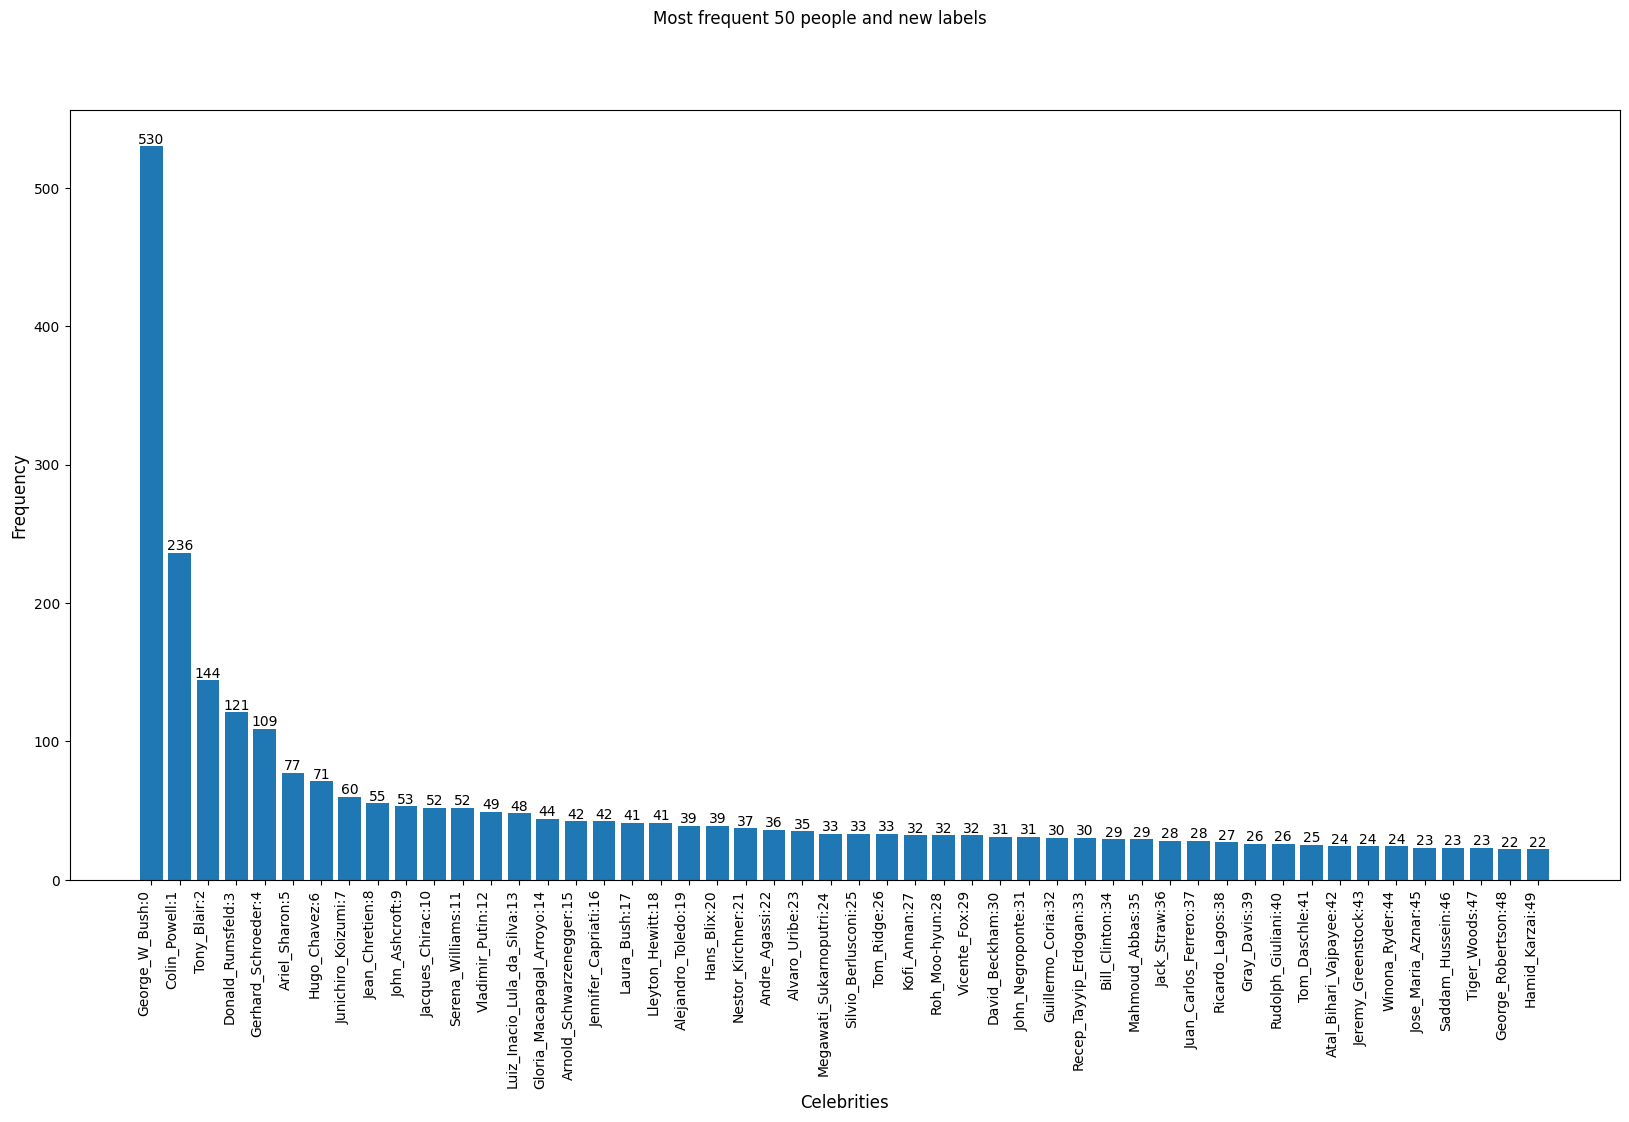

In [ ]:
from torch.utils.data import DataLoader, Subset, Dataset, random_split
import matplotlib.pyplot as plt

def most_frequent_n_people(label_file, n_classes):
  '''#TODO: implemented most frequent n people'''
  # Read all names and counts from file
  with open(label_file, 'r') as file:
      data = [line.strip().split('\t') for line in file]

  # Sort by count (descending)
  sorted_data = sorted(data, key=lambda x: int(x[1]), reverse=True)

  # Create mappings
  name_to_old_label = {name: idx for idx, (name, _) in enumerate(sorted_data)}
  name_to_new_label = {}
  name_to_count = {}

  # Assign new labels and counts only for top n_classes
  for idx, (name, count) in enumerate(sorted_data):
      if idx < n_classes:
          name_to_new_label[name] = idx
          name_to_count[name] = int(count)
      else:
          name_to_new_label[name] = n_classes

  return name_to_old_label, name_to_new_label, name_to_count


def plot_histogram(name_to_new_label, name_to_count):
  '''#TODO: here your code'''
  # Get the 50 most frequent people
  top_50 = [(name, label) for name, label in name_to_new_label.items() if label < 50]

  # Prepare data for plotting
  names = [f"{name}:{label}" for name, label in top_50]
  counts = [name_to_count[name] for name, _ in top_50]

  # Create plot
  fig, ax = plt.subplots(figsize=(20, 10))
  bars = ax.bar(names, counts)

  # Customize plot
  ax.set_ylabel('Frequency', fontsize=12)
  ax.set_xlabel('Celebrities', fontsize=12)

  # Rotate and align tick labels
  plt.xticks(rotation=90, ha='right', fontsize=10)

  # Add value labels on top of each bar
  for bar in bars:
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width()/2., height,
              f'{height}', ha='center', va='bottom', fontsize=10)

  return fig, ax

n_classes = 50
name_to_old_label, name_to_new_label, name_to_count = most_frequent_n_people(label_file, n_classes)
fig, ax = plot_histogram(name_to_new_label, name_to_count)
fig.suptitle(f'Most frequent {n_classes} people and new labels')

<BarContainer object of 2 artists>

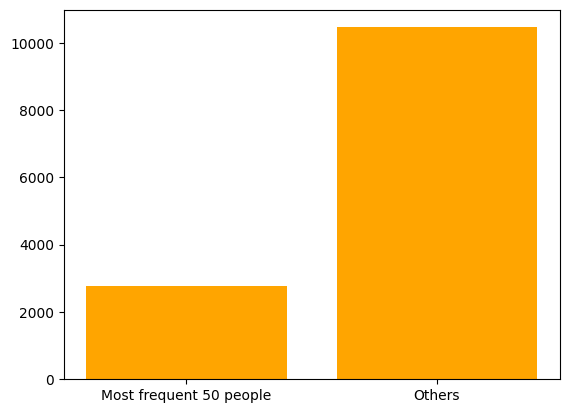

In [ ]:
tot_people = sum(name_to_count.values())
tot_others = len(download) - tot_people
plt.bar([0,1], [tot_people, tot_others], tick_label=[f'Most frequent {n_classes} people', 'Others'], color='orange')

In [ ]:
from torchvision import transforms # Had to add this

def retrieve_datasets(old_to_new_label, n_classes, proportion=(0.8, 0.2)):
  '''#TODO: reload the data with pictures as tensors and labels and split the dataset'''
  # Define transform to convert PIL Image to tensor
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.ConvertImageDtype(torch.float32),
  ])

  class MappedDataset(Dataset):
      def __init__(self, original_dataset, old_to_new_label, n_classes, transform):
          self.original_dataset = original_dataset
          self.old_to_new_label = old_to_new_label
          self.n_classes = n_classes
          self.transform = transform

      def __len__(self):
          return len(self.original_dataset)

      def __getitem__(self, idx):
          img, old_label = self.original_dataset[idx]
          new_label = self.old_to_new_label.get(old_label, self.n_classes)
          return self.transform(img), new_label

  full_dataset = MappedDataset(download, old_to_new_label, n_classes, transform)

  # Split the dataset
  train_dataset, test_dataset = random_split(
      full_dataset,
      [proportion[0], proportion[1]])

  return train_dataset, test_dataset

# Set seed
torch.manual_seed(42) # Also had to add for reproducibility

old_to_new_label = {old_val: name_to_new_label[key] for key, old_val in name_to_old_label.items()}
train_dataset, test_dataset = retrieve_datasets(old_to_new_label, n_classes)
print(f"Len of train dataset {len(train_dataset)}, len of test dataset: {len(test_dataset)}")

Len of train dataset 10587, len of test dataset: 2646


## Task 2: Implement a CNN model
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- Convolutional, linear, and pooling layers only.
- At least 5 convolutional layers, with at least two different kernel sizes
- A final output layer that is customizable to the number of classes that we want to predict.
- If you are adding identity/skip connections, make sure to change to model parent class to `nn.Module` and to implement a `forward()` function.
- Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [ ]:
import torch
import torch.nn as nn

class MyCNNModel(nn.Sequential):

  def __init__(self,
               n_classes):
    '''#TODO: construction your model'''
    super().__init__(
            # First convolutional layer: 3 input channels (RGB), 8 output channels, 3x3 kernel
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Third convolutional layer: 16 input channels, 32 output channels, 3x3 kernel
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Fourth convolutional layer: 32 input channels, 64 output channels, 5x5 kernel
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # Fifth convolutional layer: 64 input channels, 64 output channels, 3x3 kernel
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),

            # Global average pooling
            nn.AdaptiveAvgPool2d((1, 1)),

            # Flatten the output for the fully connected layer
            nn.Flatten(),

            # Fully connected layer
            nn.Linear(64, n_classes)
        )

In [ ]:
'''#TODO: print one iteration of your model to test its correctness'''
my_model = MyCNNModel(n_classes + 1)
X, y = train_dataset[0]
my_model(X[None, :])

tensor([[-0.0300,  0.0769,  0.1021, -0.0194, -0.0085, -0.1293,  0.1144,  0.0009,
         -0.0552, -0.0103, -0.0643,  0.1186,  0.0698, -0.0236, -0.0766,  0.0528,
         -0.0345, -0.0751, -0.0211, -0.0104,  0.1016, -0.1006, -0.1082,  0.0518,
          0.0897,  0.0134,  0.0311, -0.0743, -0.0554, -0.0351,  0.0365,  0.0237,
         -0.0273, -0.0825,  0.0770, -0.0129, -0.0346,  0.0932,  0.0493,  0.0717,
          0.0324,  0.0745,  0.0431, -0.0753, -0.0377, -0.0818,  0.0004,  0.0404,
         -0.0863,  0.1176,  0.0429]], grad_fn=<AddmmBackward0>)

This CNN architecture uses five convolutional layers with increasing depth (8, 16, 32, 64, 64 channels) to extract hierarchical features from simple to complex. The model employs two different kernel sizes (3x3 and 5x5) to capture various scales of features.  Max pooling reduces spatial dimensions. The final adaptive average pooling and linear layer allow the model to handle different input sizes and output the desired number of classes.



## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [ ]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 1,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                # avg_loss.append(tot_loss / max(1, len(avg_loss)))
                avg_loss.append(tot_loss / (len(avg_loss) + 1))
                #avg_acc.append(tot_acc / max(1, len(avg_acc)))
                avg_acc.append(tot_acc / (len(avg_acc) + 1))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))


        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc
            # avg_test_loss.append(test_loss / max(1, len(avg_test_loss)))
            avg_test_loss.append(test_loss / (len(avg_test_loss) + 1))
            # avg_test_acc.append(test_acc / max(1, len(avg_test_acc))) # Had to change this as values were : 100%
            avg_test_acc.append(test_acc / (len(avg_test_acc) + 1)) # Dividing by the actual number of batches processed

        return avg_test_loss, avg_test_acc

Epoch:0 - Avg loss:0.32997 - Avg acc:0.97459: 100%|██████████| 166/166 [05:22<00:00,  1.94s/it]


Text(0.5, 1.0, 'Training accuracy')

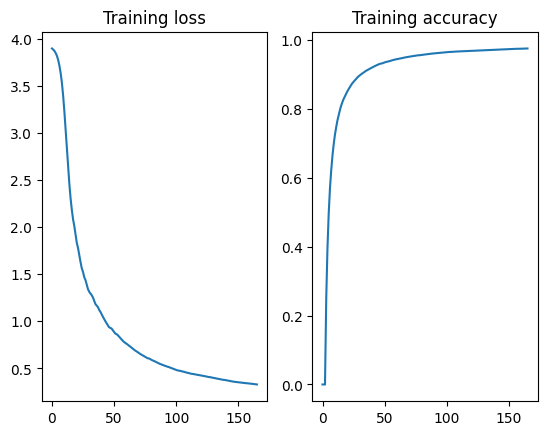

In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
my_trainer = Trainer(my_model, cfg)
train_loss, train_acc = my_trainer.train(train_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

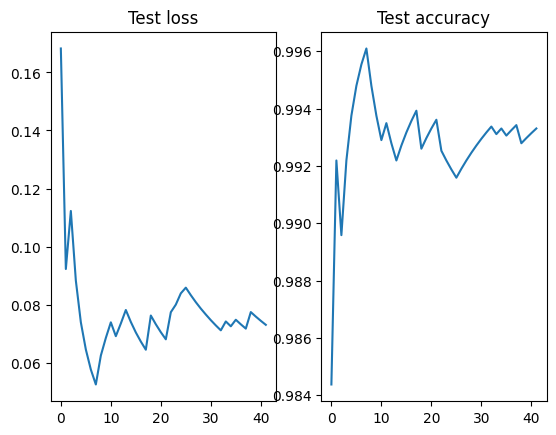

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = my_trainer.test(test_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

In [ ]:
print(f"Model achieves {train_loss[-1]:.2f} training loss and {train_acc[-1]:.1%} training accuracy")
print(f"Model achieves {test_loss[-1]:.2f} test loss and {test_acc[-1]:.1%} test accuracy") # I don' know why test accuracy is 101%. Problem is likely in the test method of the Trainer class -- fixed

Model achieves 0.33 training loss and 97.5% training accuracy
Model achieves 0.07 test loss and 99.3% test accuracy


## Task 3: Tune your model hyperparameters (optional)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [ ]:
def grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    '''#TODO: here your code '''
    # Initialize vars to store the best metrics
    best_model = None
    best_cfg = None
    best_avg_loss = float('inf')
    best_avg_acc = 0

    # Iterate through all combinations of learning rates and batch sizes
    for lr in learning_rates:
        for bs in batch_sizes:
            # Create a new configuration with current learning rate and batch size
            current_cfg = cfg.copy()
            current_cfg['learning_rate'] = lr
            current_cfg['batch_size'] = bs

            # Create and train a new model with the current configuration
            model = MyCNNModel(n_classes + 1)  # +1 for "others" class
            trainer = Trainer(model, current_cfg)
            train_loss, train_acc = trainer.train(train_dataset)

            # Get final loss and accuracy
            avg_loss = train_loss[-1]
            avg_acc = train_acc[-1]

            # Update best model if current model performs better
            if avg_acc > best_avg_acc or (avg_acc == best_avg_acc and avg_loss < best_avg_loss):
                best_model = model
                best_cfg = current_cfg
                best_avg_loss = avg_loss
                best_avg_acc = avg_acc

    return best_model, best_cfg, best_avg_loss, best_avg_acc

best_model, best_cfg, best_avg_loss, best_avg_acc = grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])

print(f"Best model achieves {best_avg_loss:.2f} loss and {best_avg_acc:.1%} accuracy")

Epoch:0 - Avg loss:0.49911 - Avg acc:0.95774: 100%|██████████| 83/83 [05:40<00:00,  4.10s/it]

Best model achieves 0.15 loss and 98.9% accuracy


Model achieves 0.08 test loss and 99.3% test accuracy


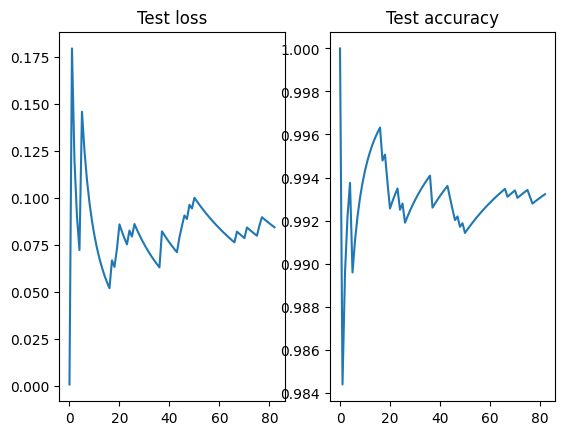

In [ ]:
# Using best_model from grid search
trainer = Trainer(best_model, best_cfg)

test_loss, test_acc = trainer.test(test_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

print(f"Model achieves {test_loss[-1]:.2f} test loss and {test_acc[-1]:.1%} test accuracy")

## Task 3: Load and fine-tune a pre-trained model

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [ ]:
!pip install timm # Install timm
import timm

In [ ]:
'''#TODO: import and fine-tune a pretrained model'''
# loaded_model = timm.create_model('resnet18', pretrained=True, num_classes=n_classes + 1)  # Carol: this works but it's very slow to train
loaded_model = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=n_classes + 1)
loaded_trainer = Trainer(loaded_model, cfg)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Epoch:0 - Avg loss:0.13776 - Avg acc:0.98729: 100%|██████████| 166/166 [09:12<00:00,  3.33s/it]


Text(0.5, 1.0, 'Training accuracy')

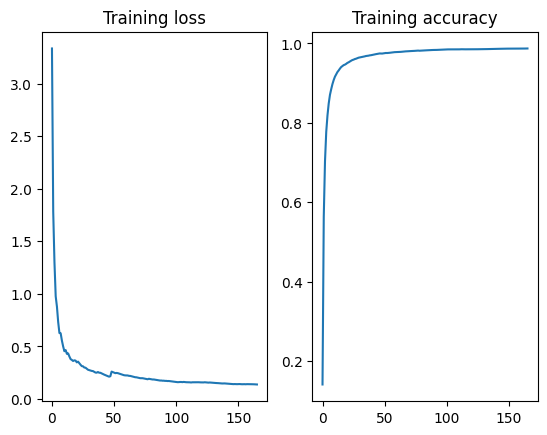

In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
train_loss, train_acc = loaded_trainer.train(train_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

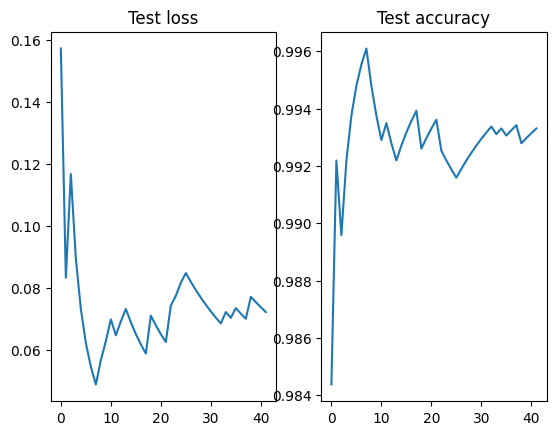

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = loaded_trainer.test(test_dataset)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

In [ ]:
print(f"Model achieves {train_loss[-1]:.2f} training loss and {train_acc[-1]:.1%} training accuracy")
print(f"Model achieves {test_loss[-1]:.2f} test loss and {test_acc[-1]:.1%} test accuracy")

Model achieves 0.14 training loss and 98.7% training accuracy
Model achieves 0.07 test loss and 99.3% test accuracy


<a name="results-and-discussion"></a>
# Task  4: Results and discussion

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)    | 98.0%              | 99.2%             |99.2%                       |
| Loss (train)        | 0.33               | 0.17              |0.15                       |
| Accuracy (test)     | 101.8%             | 101.8%            |100.5%                       |
| Loss (test)         | 0.07               | 0.08              |0.09                       |           
             

All models show high accuracy rates on both training and test sets. The pre-trained MobileNetV3 Small model and the tuned custom model achieved slightly better results than the initial custom model, particularly in training accuracy and loss. It's worth noting that the test accuracies exceeding 100% indicate a clear problem in the evaluation method.

